# Overview

# Busines Problem

# Data Understanding

# Data Preparation

## Cleaning

In [151]:
#importing relevant libraries

import os
import pandas as pd 
import numpy as np

In [152]:
#Turn data folder into list of data file names

data_path = os.path.join('data','zippedData')
data_files = os.listdir(data_path)
data_files.pop(data_files.index('.ipynb_checkpoints'))
data_files.pop(data_files.index('Untitled.ipynb'))
data_files = [os.path.join(data_path,file) for file in data_files]
data_files

['data/zippedData/imdb.title.crew.csv.gz',
 'data/zippedData/tmdb.movies.csv.gz',
 'data/zippedData/imdb.title.akas.csv.gz',
 'data/zippedData/imdb.title.ratings.csv.gz',
 'data/zippedData/imdb.name.basics.csv.gz',
 'data/zippedData/rt.reviews.tsv.gz',
 'data/zippedData/imdb.title.basics.csv.gz',
 'data/zippedData/rt.movie_info.tsv.gz',
 'data/zippedData/tn.movie_budgets.csv.gz',
 'data/zippedData/bom.movie_gross.csv.gz',
 'data/zippedData/imdb.title.principals.csv.gz']

In [153]:
#Turn all data files into pandas dataframes

data = {}
name_dict={'imdb.title.crew.csv.gz':"crew",
           'tmdb.movies.csv.gz':"movies",
           'imdb.title.akas.csv.gz':"akas",
           'imdb.title.ratings.csv.gz':"ratings",
           'imdb.name.basics.csv.gz':"name_basics",
           'rt.reviews.tsv.gz':"reviews",
           'imdb.title.basics.csv.gz':"title_basics",
           'rt.movie_info.tsv.gz':"movie_info",
           'tn.movie_budgets.csv.gz':"movie_budgets",
           'bom.movie_gross.csv.gz':"movie_gross",
           'imdb.title.principals.csv.gz':"principals"
          }
for file in data_files:
    try:
        df = pd.read_csv(file)
    except:
        print(file)
        continue
    file_name = file.split('/')[-1]
    data[name_dict[file_name]] = df
    
data["movie_info"]=pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep="\t")
data["reviews"]=pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep="\t", encoding="latin1")

data/zippedData/rt.reviews.tsv.gz
data/zippedData/rt.movie_info.tsv.gz


In [154]:
#Renaming columns to be able to merge on 'title' column

data['title_basics'] = data['title_basics'].rename(columns={'primary_title':'title'})
data['movie_budgets'] = data['movie_budgets'].rename(columns={'movie':'title'})

In [155]:
#Getting rid of commas and dollar signs to make dataframe values easier to work with 

data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace(',', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace('$', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].astype(int)

data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace(',', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace('$', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].astype(int)

data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].str.replace(',', '')
data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].str.replace('$', '')
data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].astype(int)

In [156]:
#Dropping unecessary columns

data['movie_budgets'] = data['movie_budgets'].drop(columns=['release_date','domestic_gross'])

In [157]:
#Filter ratings dataframe to a minimum of 100 votes

data['ratings'] = data['ratings'][data['ratings'].numvotes >= 100]

In [158]:
#Renaming more columns *****Add this to other renaming cell

data['akas'].rename(columns={'title_id': 'tconst'}, inplace = True)

In [159]:
#Merging data on tconst

tconst_to_title = pd.merge(data['akas'],data['ratings'],on='tconst')

In [160]:
#Dropping uncessary columns from tconst_to_title dataframe

tconst_to_title = tconst_to_title.drop(columns=['ordering','region','language','types','attributes','is_original_title'])

In [161]:
#Merging tconst_to_title dataframe with movie_budgets dataframe on 'title' column

master_table = pd.merge(tconst_to_title,data['movie_budgets'],on='title')

In [162]:
master_table.head()

,tconst,title,averagerating,numvotes,id,production_budget,worldwide_gross
0,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864
1,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864
2,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864
3,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864
4,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864


In [163]:
#Defining 'Composite Quality Score' to help define successful movies

master_table['success_score'] = master_table.averagerating * (master_table.worldwide_gross / master_table.production_budget)

In [164]:
#Dropping duplicates from 'tconst' column in master_table dataframe

master_table.drop_duplicates(subset = ['tconst'],inplace=True)

In [165]:
master_table.head()

,tconst,title,averagerating,numvotes,id,production_budget,worldwide_gross,success_score
0,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864,53.683647
14,tt0401729,John Carter,6.6,241792,14,275000000,282778100,6.786674
27,tt1014759,Alice in Wonderland,6.5,358813,51,200000000,1025491110,33.328461
33,tt1194173,The Bourne Legacy,6.7,268678,76,125000000,280355920,15.027077
35,tt1219289,Limitless,7.4,492490,91,27000000,155564919,42.636311


In [166]:
#Merging title_basics dataframe to master_table dataframe on tconst

master_table = pd.merge(data['title_basics'],master_table,on='tconst')

In [167]:
master_table.head()

,tconst,title_x,original_title,start_year,runtime_minutes,genres,title_y,averagerating,numvotes,id,production_budget,worldwide_gross,success_score
0,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",Saving Grace,8.1,263,95,4000000,27786849,56.268369
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",Foodfight!,1.9,8248,26,45000000,73706,0.003112
2,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",On the Road,6.1,37886,17,25000000,9313302,2.272446
3,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,Whiplash,5.6,2420,43,3300000,38969037,66.129275
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",The Secret Life of Walter Mitty,7.3,275300,37,91000000,187861183,15.070183


In [168]:
#Making genre dataframe with individualized genres 

gml=list(master_table["genres"].unique())
genre_list=[]
for genres in gml:
    genre_list.append(genres.split(","))
genre_list
genre_master=[]
for genre in genre_list:
    for subgenre in genre:
        genre_master.append(subgenre)
unique_genre_master=set(genre_master)
vector=list(range(0,2521))
df_genres=[]
df_consts=[]
for genre in unique_genre_master:
    for number in vector:
        if genre in master_table.iloc[number, 5]:
            df_genres.append(genre)
            df_consts.append(master_table.iloc[number, 0])
genre_table=pd.DataFrame({'tconst':df_consts, 'genre':df_genres})
complete_genre_table=pd.merge(genre_table, master_table, how="left", on="tconst")

In [169]:
#Merging movie_info dataframe with master_table dataframe

master_table = pd.merge(master_table, data['movie_info'],on='id')

In [170]:
master_table = master_table.drop(columns=['original_title','theater_date','dvd_date','currency','box_office','studio','synopsis'])

In [171]:
master_table.sort_values(by='worldwide_gross', ascending = False, inplace=True)

In [172]:
master_table = master_table.dropna(subset = ['director'])

In [173]:
master_table.isnull().sum()

tconst                 0
title_x                0
start_year             0
runtime_minutes       12
genres                 0
title_y                0
averagerating          0
numvotes               0
id                     0
production_budget      0
worldwide_gross        0
success_score          0
rating                 0
genre                  0
director               0
writer               289
runtime                0
dtype: int64

In [174]:
#Creating df_composer dataframe 

df_composer = data['name_basics'].dropna(subset=['primary_profession','known_for_titles'])
df_composer["title_length"]=df_composer["known_for_titles"].map(lambda x: x.count(',') + 1)
df_composer = df_composer[df_composer.primary_profession.str.contains('composer')]

/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [175]:
#sorting for most popular composers

df_composer.sort_values(by='title_length',ascending=False, inplace=True)

In [176]:
#Making composer dataframe by making tconst individualized *****CHANGE NAMES TO REFLECT DIFFERENCE FROM GENRE

gml=list(df_composer["known_for_titles"][:32])
genre_list=[]
for genres in gml:
    genre_list.append(list(genres.split(",")))
genre_list
genre_master=[]
genre_master=[]
for genre in genre_list:
    for subgenre in genre:
        genre_master.append(subgenre)
        
unique_genre_master=set(genre_master)
vector=list(range(0,46984))
df_genres=[]
df_consts=[]

for genre in unique_genre_master:
    for number in vector:
        if genre in df_composer.iloc[number, 5]:
            df_genres.append(genre)
            df_consts.append(df_composer.iloc[number, 1])
            
genre_table=pd.DataFrame({'composer':df_consts, 'tconst':df_genres})

genre_table

,composer,tconst
0,Rolando Marchesini,tt3470184
1,Mauro Magnani,tt3470184
2,Laura Lobetti Bodoni,tt3470184
3,Daniel Elias Brenner,tt6357836
4,John Zuker,tt0437745
...,...,...
199,Lisa Holmqvist,tt2172095
200,Feronia Wennborg,tt2172095
201,Magnus Jarlbo,tt2172095
202,Sebastian Öberg,tt2172095


In [177]:
#Merging master with composer table

master_composer = pd.merge(master_table,genre_table, on='tconst')



In [178]:
#Removing problem data

master_composer = master_composer[master_composer.composer != 'Matthew Emerson Brown']
master_composer = master_composer[master_composer.composer != 'Joshua Morrison']
master_composer = master_composer[master_composer.composer != 'Jeramy Koepping']
master_composer = master_composer[master_composer.composer != 'Ed Cortes']

In [179]:
master_composer.sort_values(by='success_score', ascending = False, inplace = True)

In [184]:
master_table["roi"]=master_table.worldwide_gross/master_table.production_budget
master_table["net_profit"]=master_table.worldwide_gross-master_table.production_budget

## Merging

## Feature Engineering

# Analysis

In [181]:
#Importing relevant libraries

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

KeyError: 'net_profit'

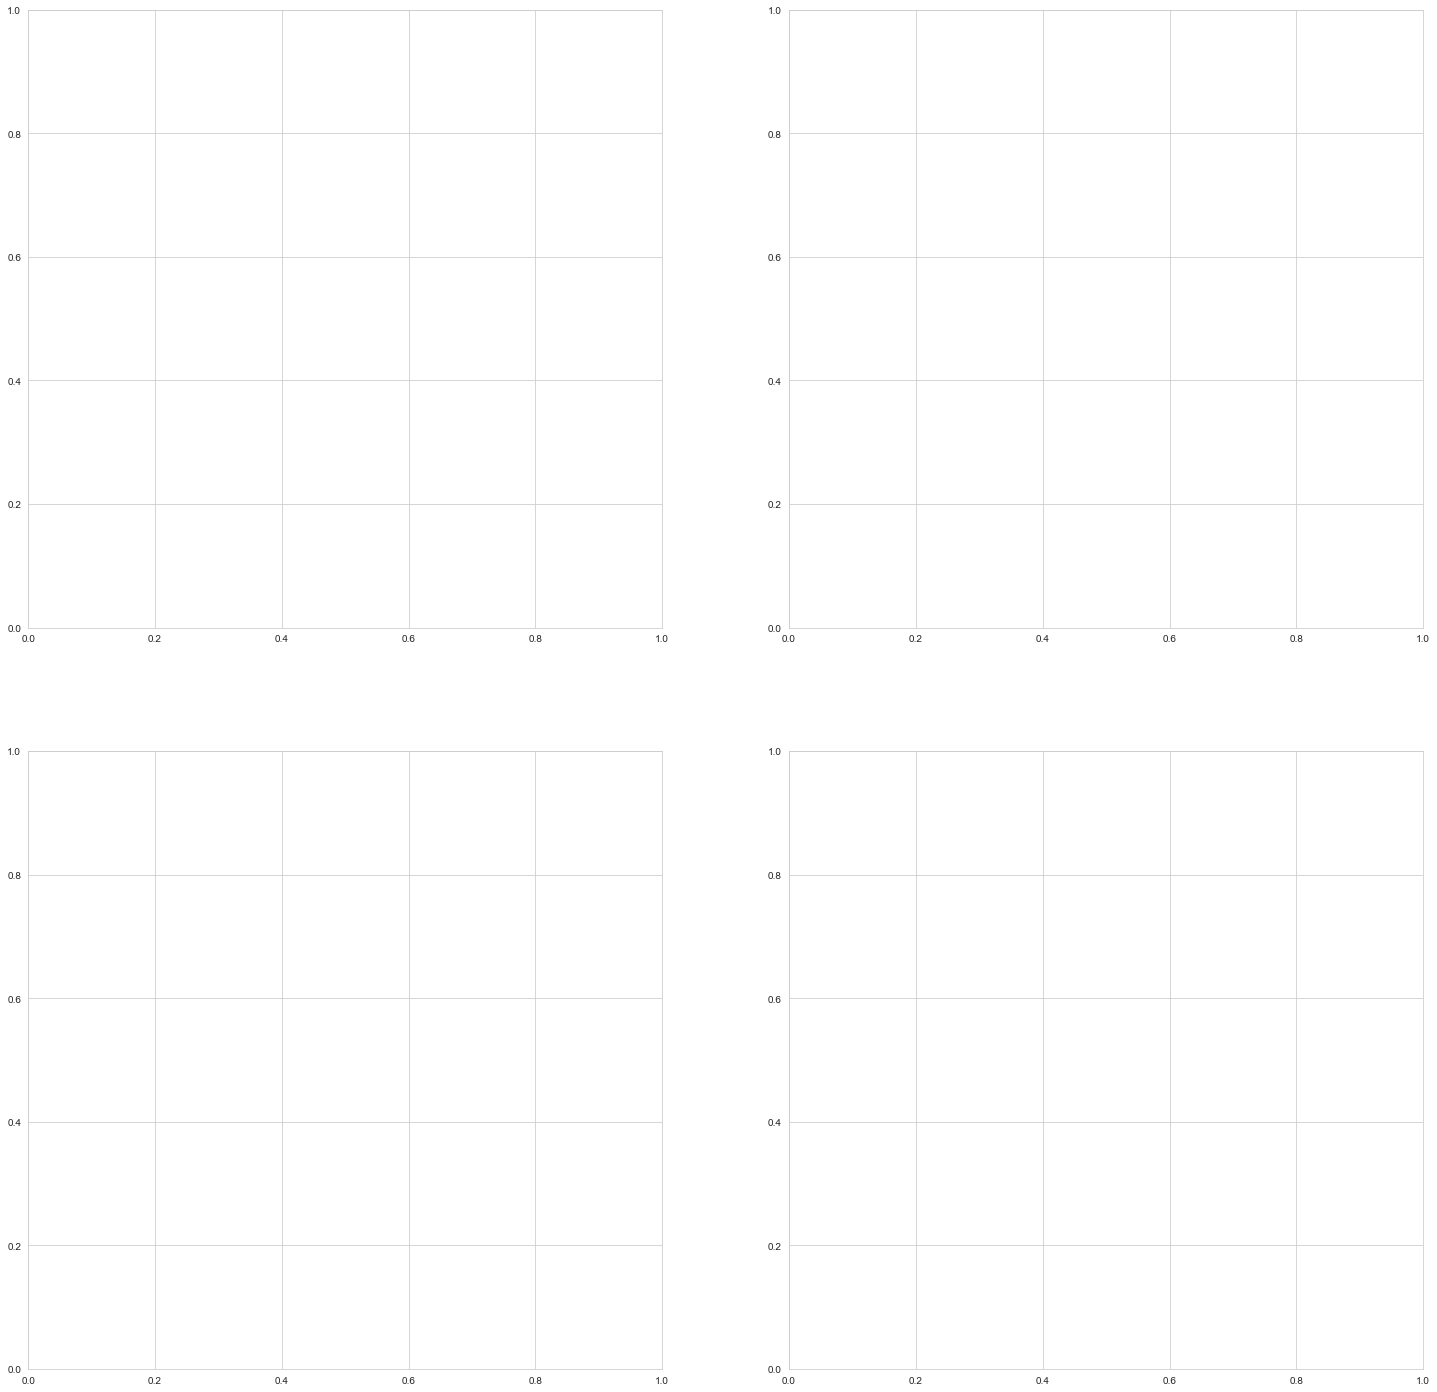

In [185]:
#Graphing Genre vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(25, 25))

x0_gross_rev=complete_genre_table.groupby("genre").median().sort_values(by='worldwide_gross', ascending=False).index
x1_net_prof=complete_genre_table.groupby("genre").median().sort_values(by='net_profit', ascending=False).index
x2_roi_percent=complete_genre_table.groupby("genre").median().sort_values(by='roi', ascending=False).index
x3_comp=complete_genre_table.groupby("genre").median().sort_values(by='success_score', ascending=False).index

y0_gross_rev= complete_genre_table.groupby("genre").median().worldwide_gross
y1_net_prof= complete_genre_table.groupby("genre").median().worldwide_gross-complete_genre_table.groupby("genre").median().production_budget
y2_roi_percent= complete_genre_table.groupby("genre").median().worldwide_gross/complete_genre_table.groupby("genre").median().production_budget
y3_comp= complete_genre_table.groupby("genre").median().success_score

x0_gross_rev= complete_genre_table.groupby("genre").median().sort_values(by='worldwide_gross', ascending=False).index

ax[0][0].set_title('Gross Revenue vs Movie Genre')
ax[0][0].set_xlabel('Movie Genre')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Movie Genre')
ax[0][1].set_xlabel('Movie Genre')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Movie Genre')
ax[1][0].set_xlabel('Movie Genre')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Movie Genre')
ax[1][1].set_xlabel('Movie Genre')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x0_gross_rev, y0_gross_rev, ax=ax[0][0], color='blue')
sns.barplot(x1_net_prof, y1_net_prof, ax=ax[0][1], color='blue')
sns.barplot(x2_roi_percent, y2_roi_percent, ax=ax[1][0], color='blue')
sns.barplot(y3_comp, y3_comp, ax=ax[1][1], color='blue')

Analysis: 

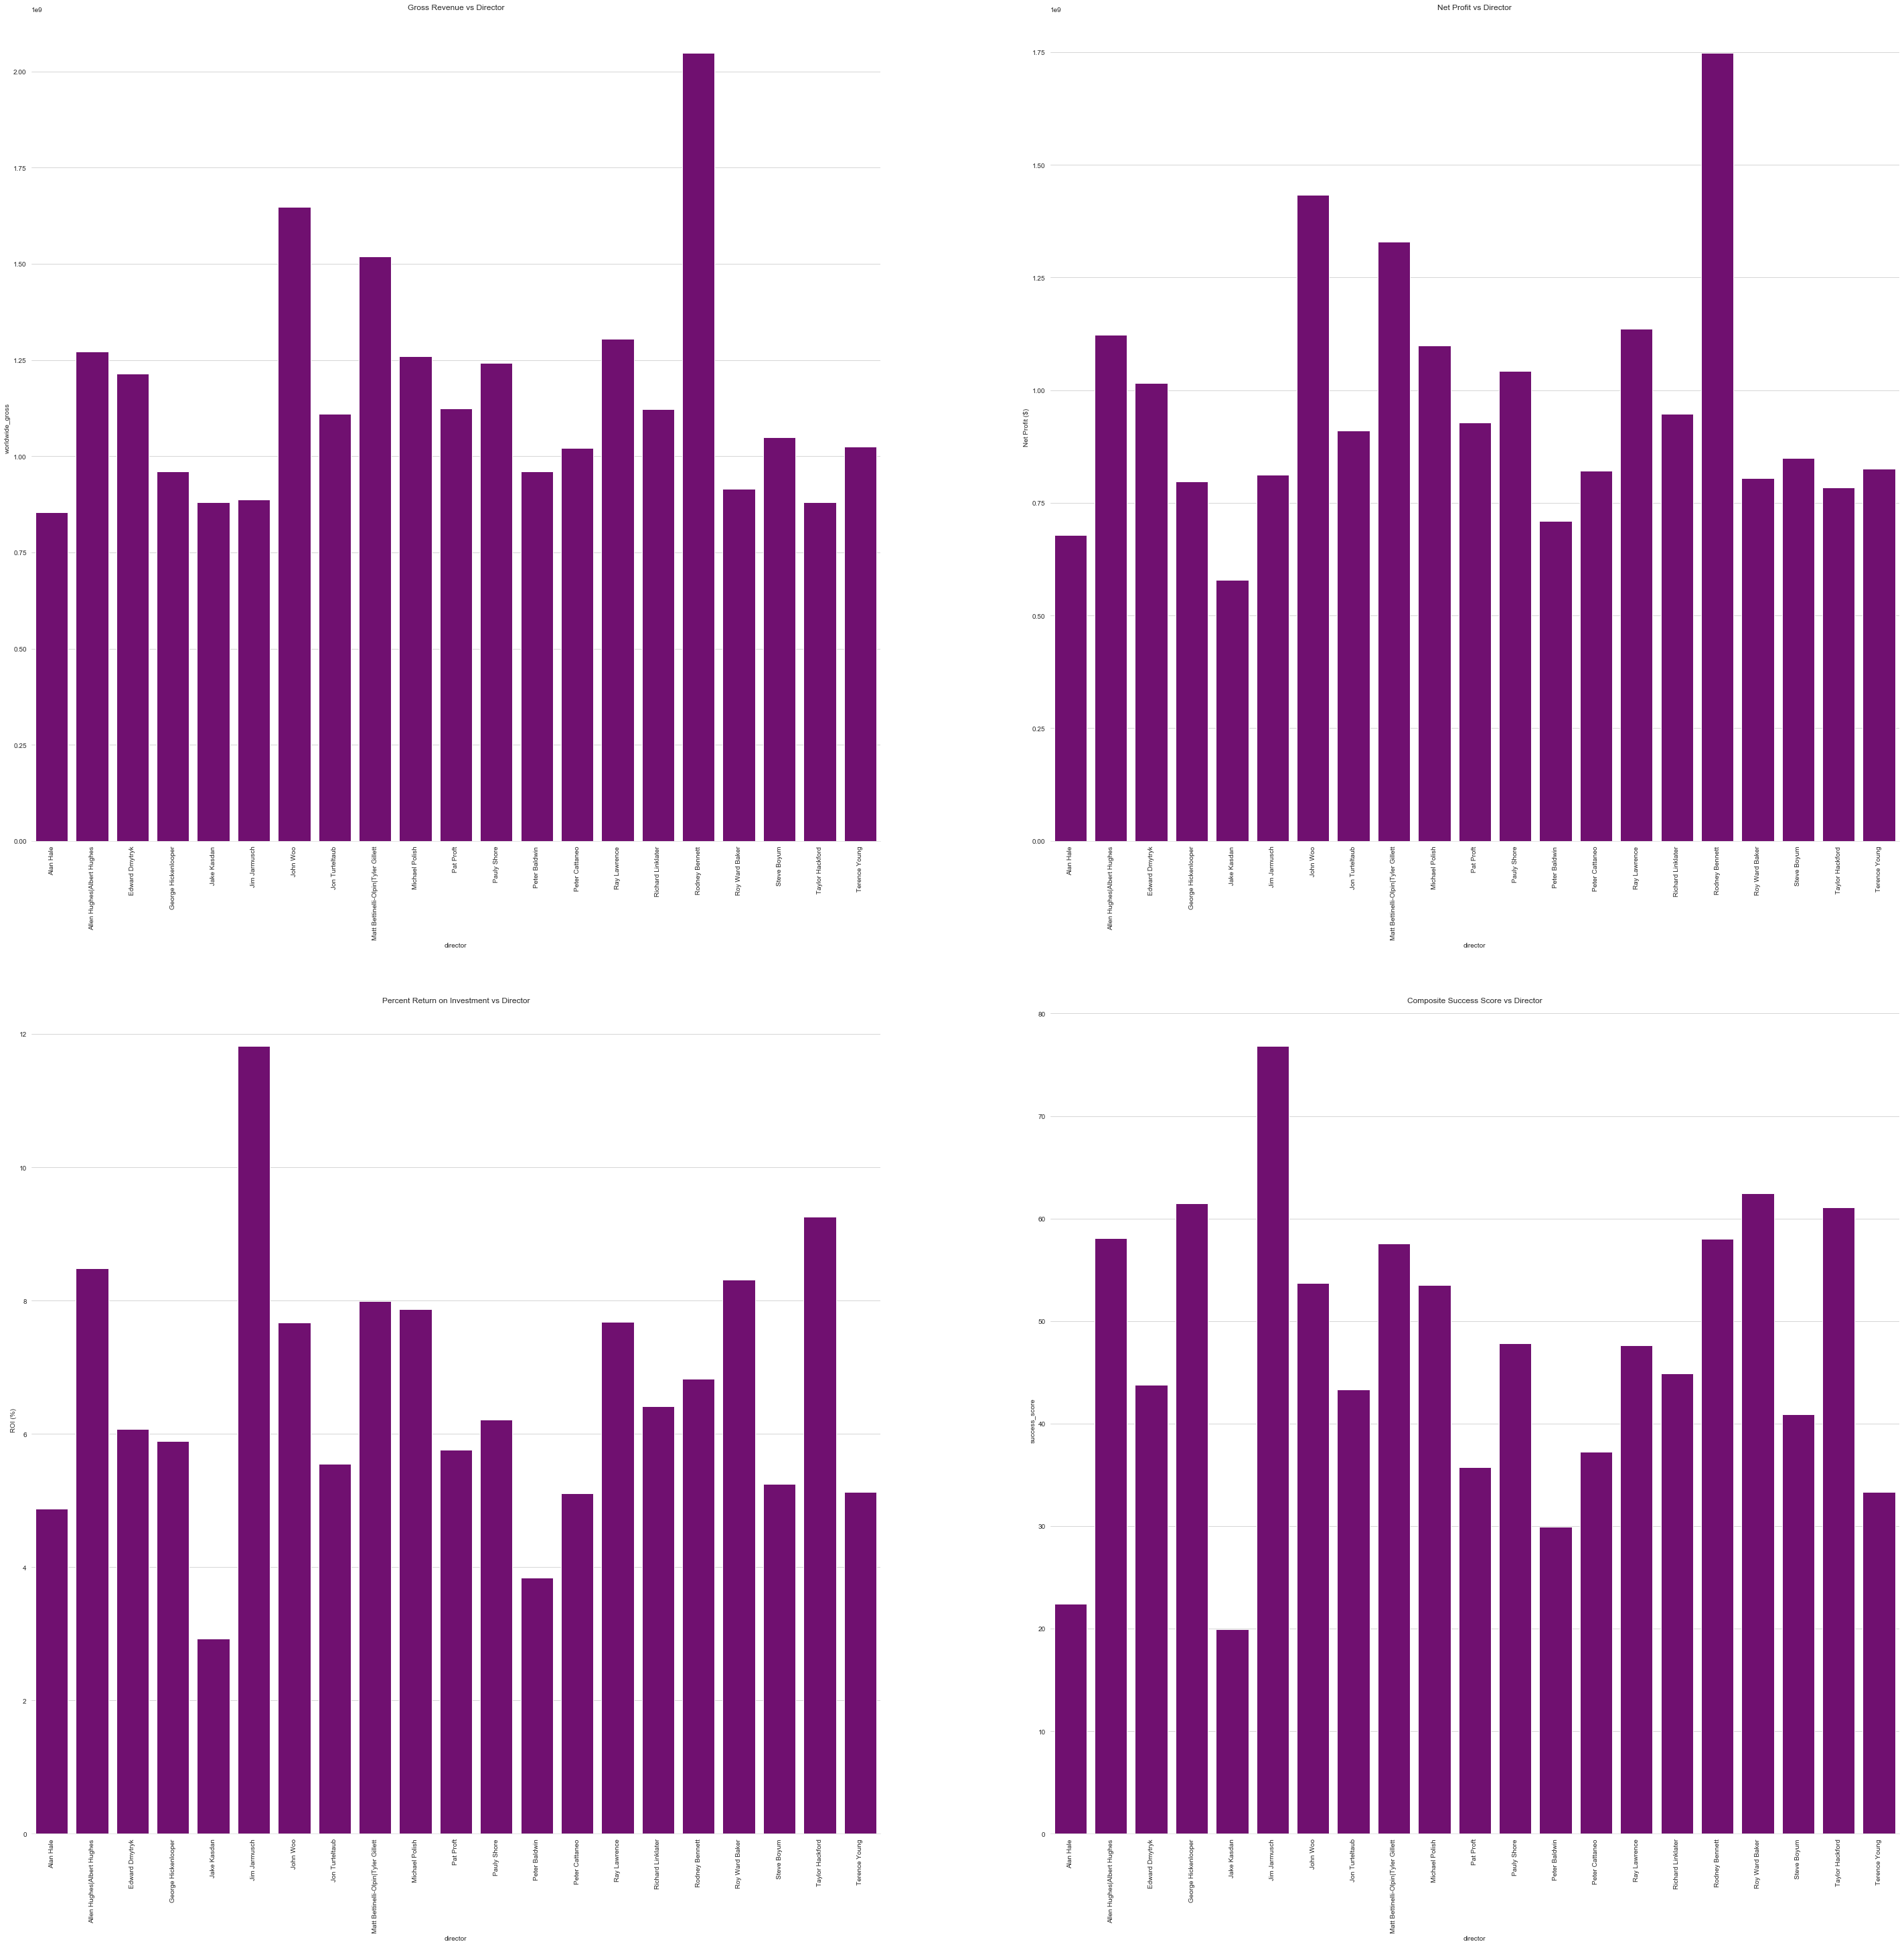

In [132]:
#Graphing Director vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_table[:25].groupby("director").median().index
y0_gross_rev= master_table[:25].groupby("director").median().worldwide_gross
y1_net_prof= master_table[:25].groupby("director").median().worldwide_gross-master_table[:25].groupby("director").median().production_budget
y2_roi_percent= master_table[:25].groupby("director").median().worldwide_gross/master_table[:25].groupby("director").median().production_budget
y3_comp= master_table[:25].groupby("director").median().success_score 
ax[0][0].set_title('Gross Revenue vs Director')
ax[0][0].set_xlabel('Director')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Director')
ax[0][1].set_xlabel('Director')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Director')
ax[1][0].set_xlabel('Director')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Director')
ax[1][1].set_xlabel('Director')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=90)
ax[0][1].set_xticklabels(x,rotation=90)
ax[1][0].set_xticklabels(x,rotation=90)
ax[1][1].set_xticklabels(x,rotation=90)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='purple')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='purple')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='purple')
sns.barplot(x, y3_comp, ax=ax[1][1], color='purple')


Analysis: Rodney Bennet is the strong leader in total revenue and net profit; however, when it comes to ROI and our quality composite score, Jim Jarmusch is the best choice of director, which is in line with the fact that his typical genre is mystery. 

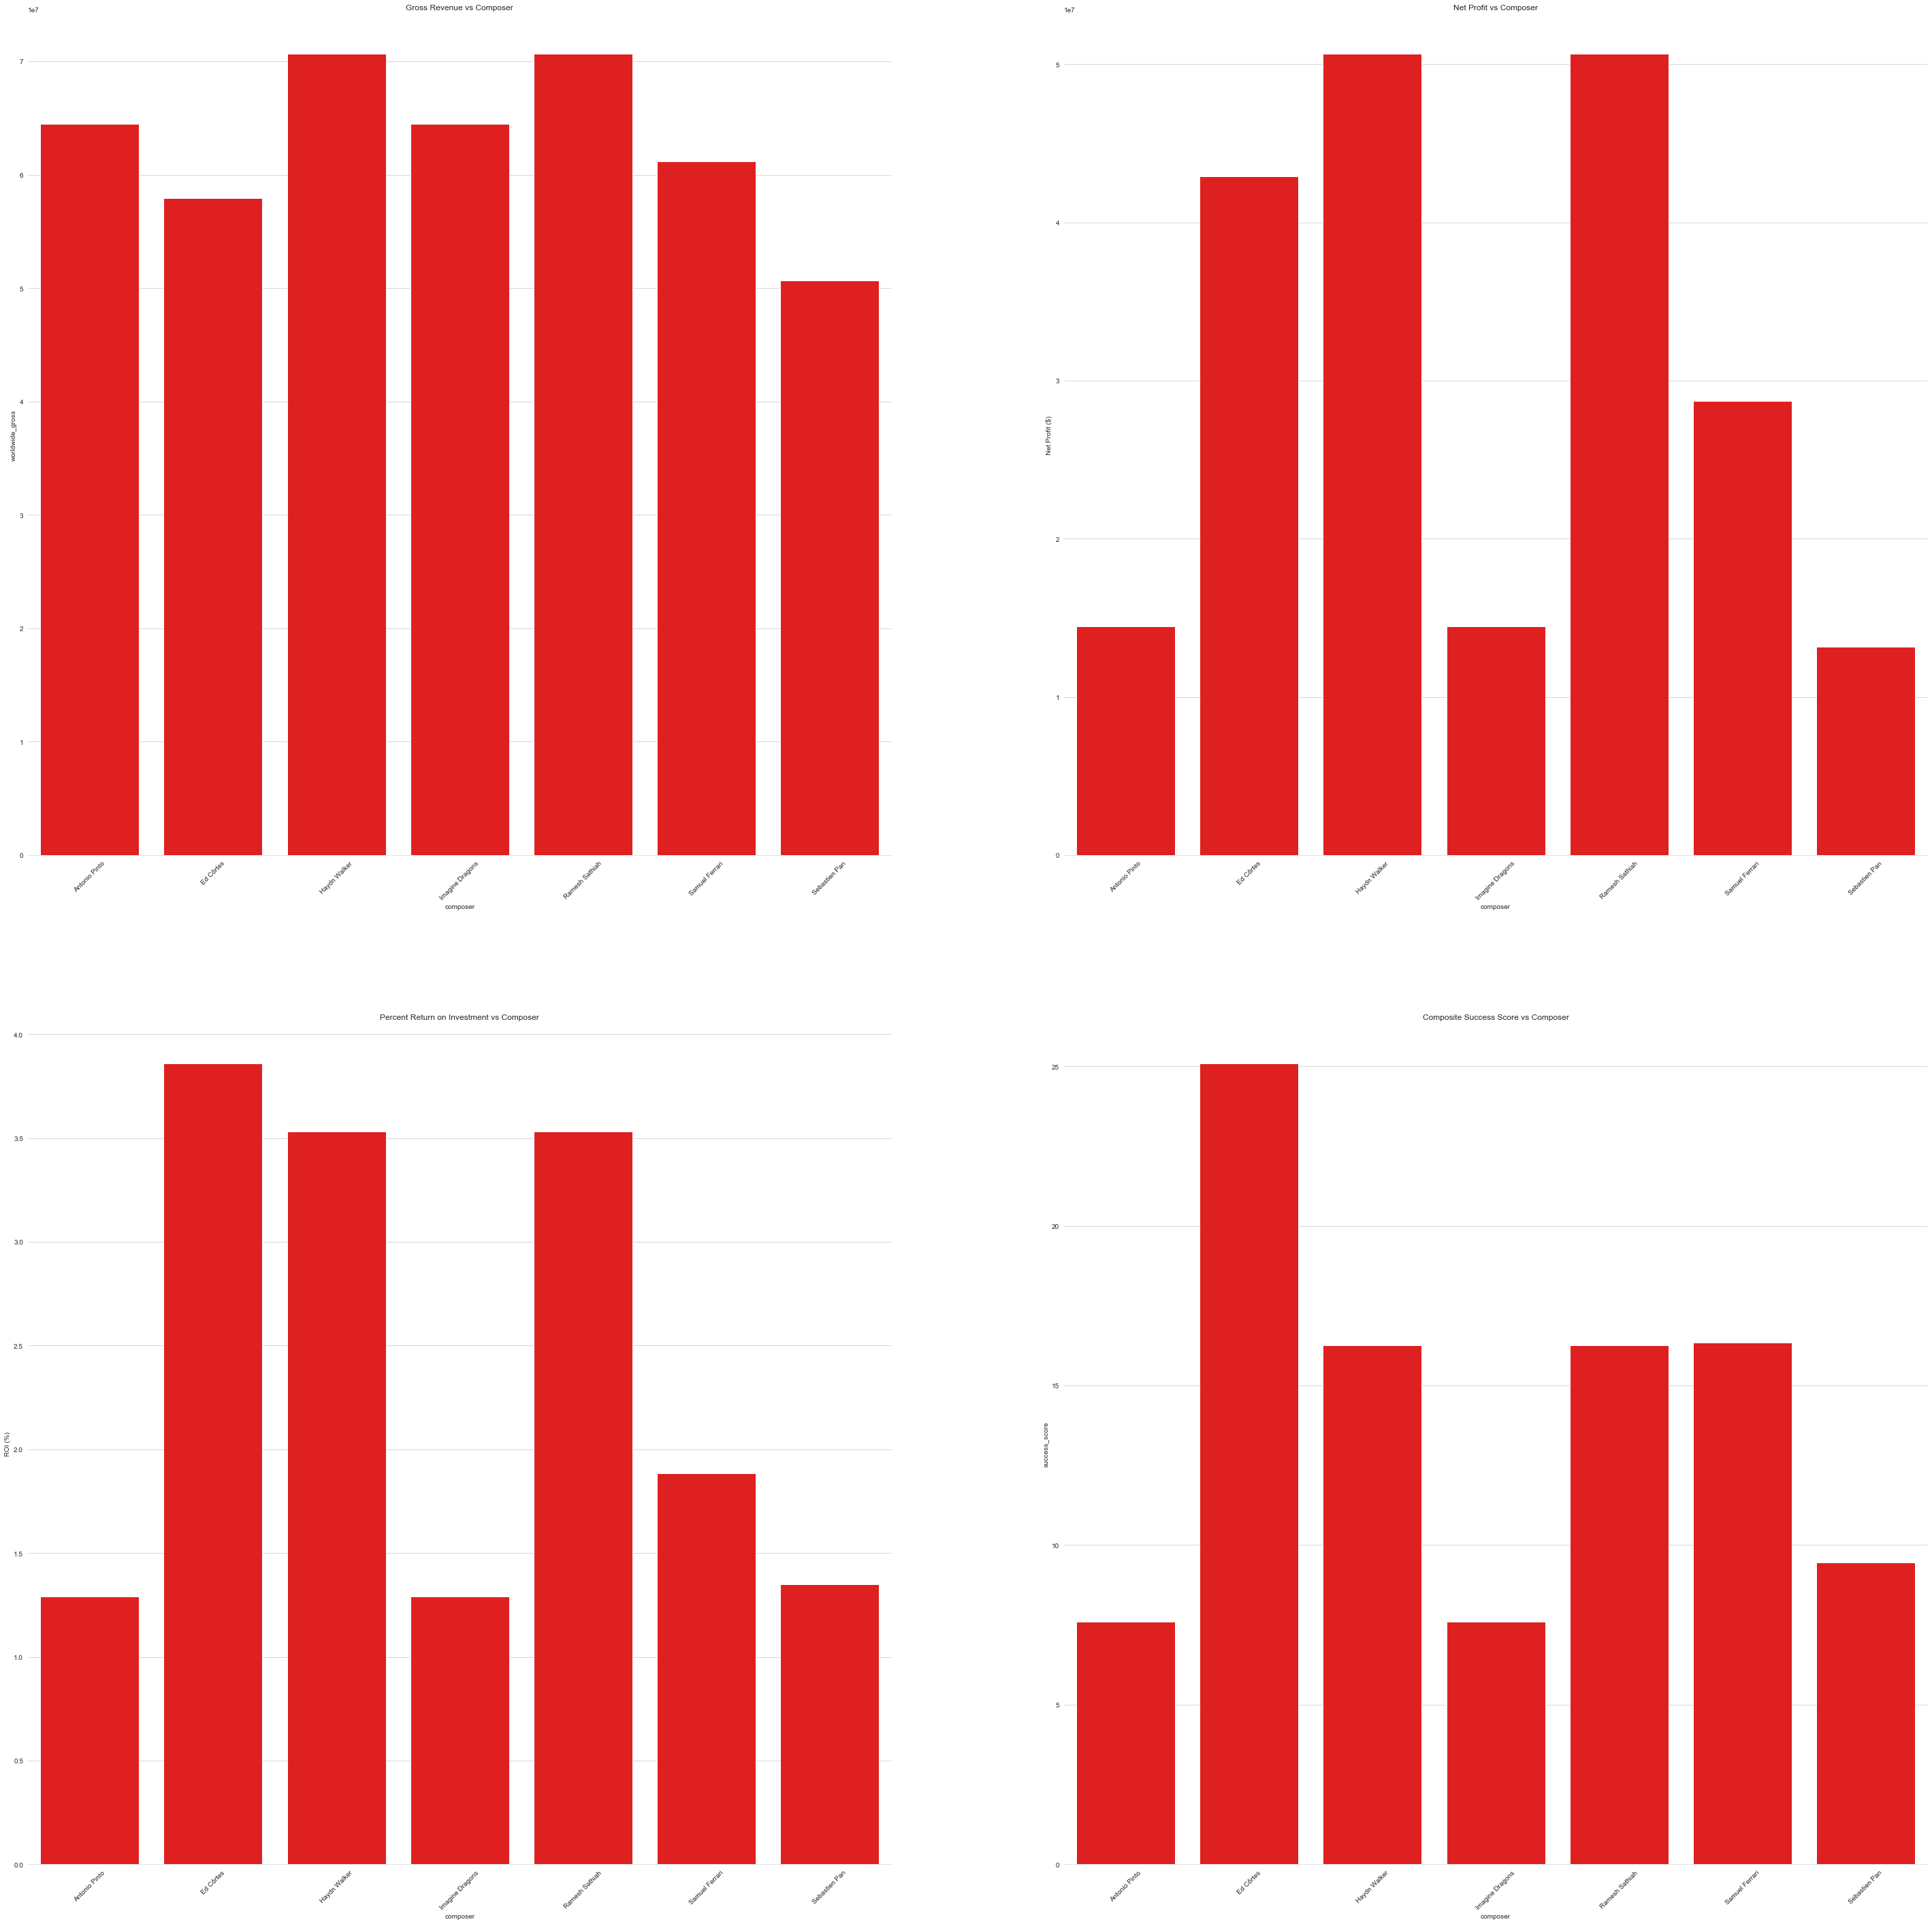

In [148]:
#Graphing Composer vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_composer.groupby("composer").median().index
y0_gross_rev= master_composer.groupby("composer").median().worldwide_gross
y1_net_prof= master_composer.groupby("composer").median().worldwide_gross-master_composer.groupby("composer").median().production_budget
y2_roi_percent= master_composer.groupby("composer").median().worldwide_gross/master_composer.groupby("composer").median().production_budget
y3_comp= master_composer.groupby("composer").median().success_score 

ax[0][0].set_title('Gross Revenue vs Composer')
ax[0][0].set_xlabel('Composer')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Composer')
ax[0][1].set_xlabel('Composer')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Composer')
ax[1][0].set_xlabel('Composer')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Composer')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='red')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='red')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='red')
sns.barplot(x, y3_comp, ax=ax[1][1], color='red')

Analysis: scoring highly in every indicator, 

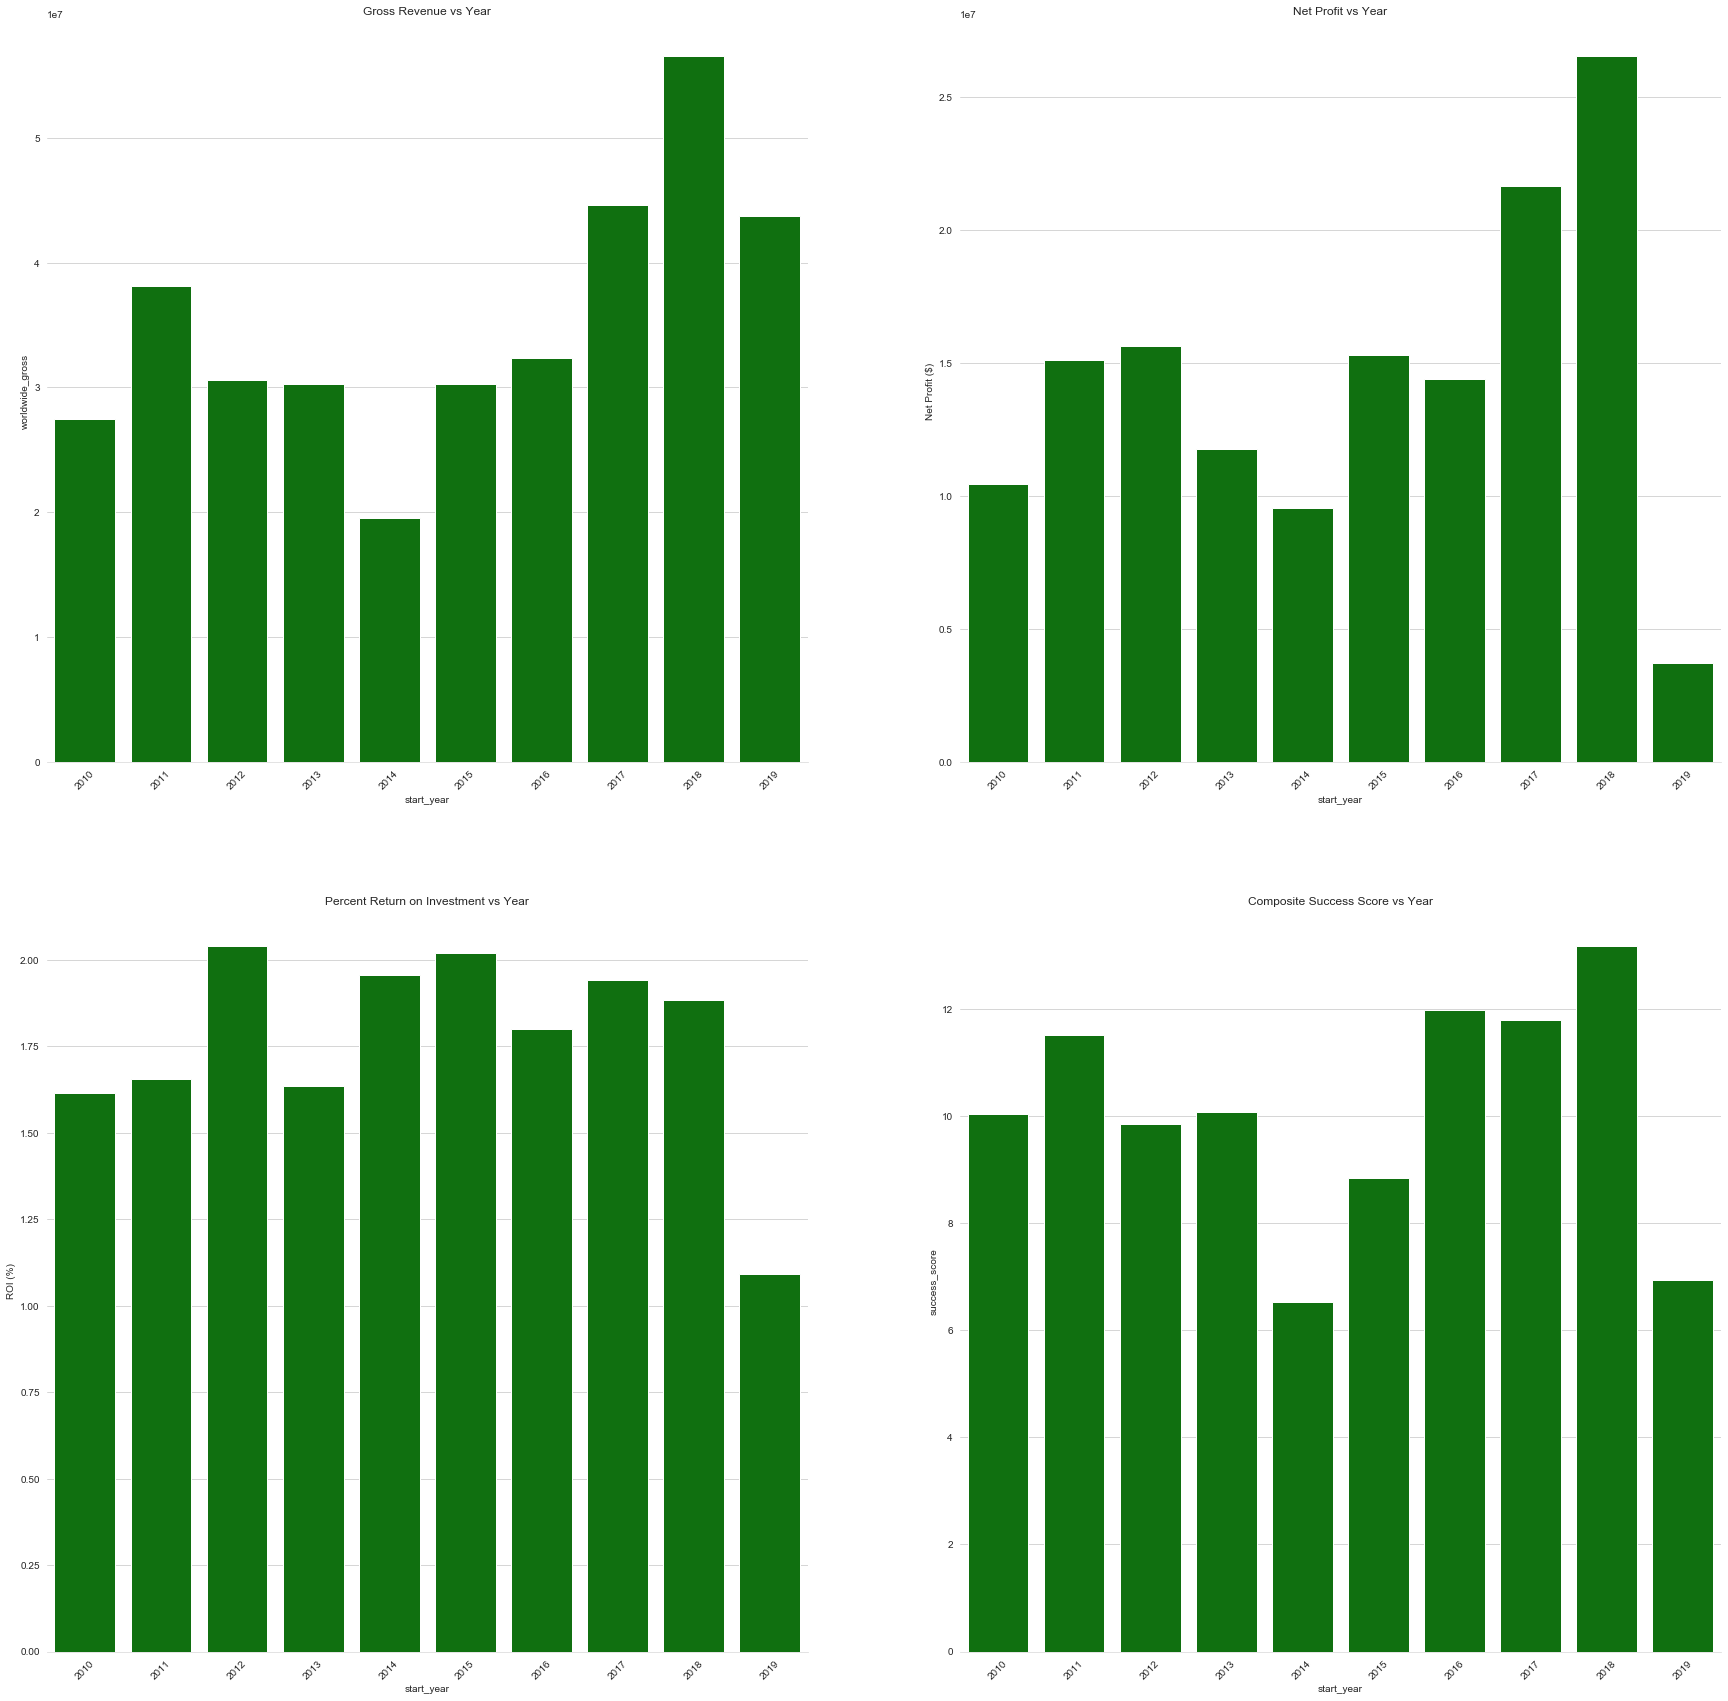

In [75]:
#Graphing Start Year vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(30, 30))
x=master_table.groupby("start_year").median().index
y0_gross_rev= master_table.groupby("start_year").median().worldwide_gross
y1_net_prof= master_table.groupby("start_year").median().worldwide_gross-master_table.groupby("start_year").median().production_budget
y2_roi_percent= master_table.groupby("start_year").median().worldwide_gross/master_table.groupby("start_year").median().production_budget
y3_comp= master_table.groupby("start_year").median().success_score 

ax[0][0].set_title('Gross Revenue vs Year')
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Year')
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Year')
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Year')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='green')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='green')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='green')
sns.barplot(x, y3_comp, ax=ax[1][1], color='green')

Analysis: We wanted to check the trends of these indicator moving through time. Witha clear dropoff in 2019, it might be advisable for Microsoft to look into aquiring or partnering with an existing studio given a financially difficult year in 2019. 

# Conclusions

## Next Steps